# Определение стоимости автомобилей

## Описание данных

Данные находятся в файле /datasets/autos.csv.

**Признаки:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

**План выполнения работы:**

- Подготовка Данных
    - 1.1 Изучение данных
    - 1.2 Предобработка данных
    - 1.3 Кодирование категориальных признаков
    - 1.4 Подготовка выборок
    
- Обучение моделей
    - 2.1 Линейная регрессия
    - 2.2 Lasso/Ridge
    - 2.3 LightGBM
    
- Анализ моделей


## 1. Подготовка данных

### 1.1 Изучение данных

- pandas - для работы с таблицами
- seaborn - для визуализации данных
- display - для вывода табличных данных
- sklearn - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

установим библиотеку "lightgbm" командой -pip

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge lightgbm

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgb

Загрузим данные из файлов, выведем первые 10 строк таблиц для первого взгляда на данные.
Также с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных.

In [4]:
# сохраняем датасет в переменную 'df'
try:
    df = pd.read_csv('/Users/artemvishanov/Desktop/yandex_practicum_project/11. Определение стоимости автомобилей/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')


In [5]:
display(df.head(10))
print(df.info())
print('Количество дубликатов:', sum(df.duplicated()))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- Признаки **NumberOfPicture** и **PostalCode**, не несут полезной информации, удалим их.
- Также **DateCrawled**, повторяет данные из **DateCreated**.
- **RegistrationMonth** по смыслу также не будет влиять на цену автомобиля

Избавимся от неинформативных признаков.

In [6]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth'], axis=1)

In [7]:
numerical_features = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

### 1.2. Предобработка данных

- Отберем признаки, которые понадобятся для построения модели
- Обработаем пропускт и выбросы 

In [8]:
# для начала удалим дубликаты 
df = df.drop_duplicates()

- Признак **Price**

In [9]:
f"Количество объявлений с нулевой ценой: {len(df.loc[df['Price'] == 0])}"

'Количество объявлений с нулевой ценой: 10771'

Данные о нулевой цене явно ошибка, их нельзя востановить, поэтому удалим, чтобы не портить модель.

In [10]:
df = df.loc[df['Price'] != 0]

<AxesSubplot:xlabel='Price', ylabel='Count'>

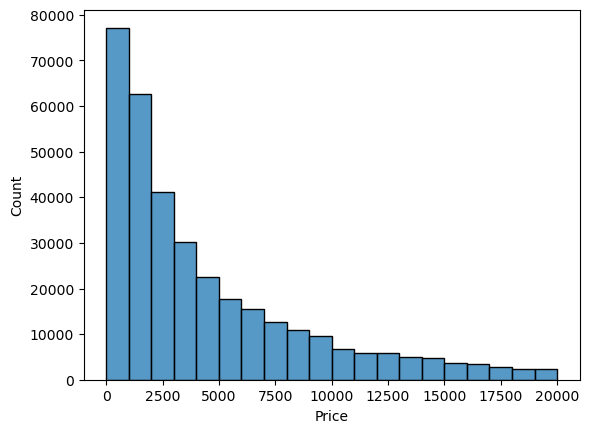

In [11]:
sns.histplot(df['Price'], bins=20)

- Признак **Model**

In [12]:
f"Количество объявлений с незаполненной моделью: {len(df.loc[df['Model'].isna()])}"

'Количество объявлений с незаполненной моделью: 17520'

Признак Model является одним из основных для предсказания цены. Пропущено 5% данных в этом признаке. Нет возможности восстановить корректно эти данные, удалим пропуски.

In [13]:
df = df.loc[~df['Model'].isna()]

- Признак **Power**

In [14]:
f"Количество автомобилей с мощностью > 1000 л.с.: {len(df.loc[(df['Power'] > 1000) | (df['Power'] <= 0)])}"

'Количество автомобилей с мощностью > 1000 л.с.: 31583'

Мощность > 1000 л.с. неправдоподобна. Заполним все непавдоподобные значения медианными среди автомобилей той же модели.

In [15]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

In [16]:
df.loc[(df['Power'] == 0)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen


<AxesSubplot:xlabel='Power', ylabel='Count'>

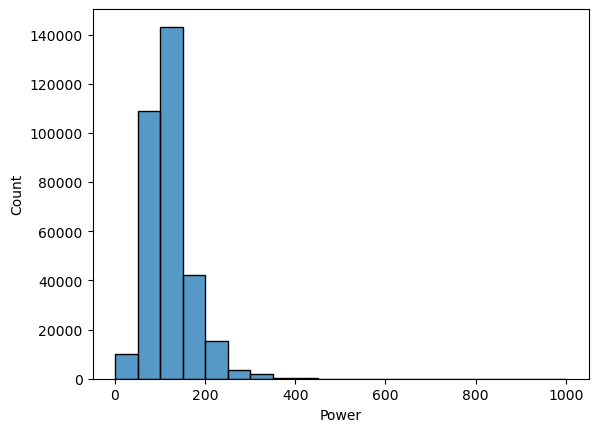

In [17]:
sns.histplot(df['Power'], bins=20)

- Признаки **DateCreated** и **LastSeen**

In [18]:
f"Минимальная дата рагистрации объявления: {min(df['DateCreated'])}"

'Минимальная дата рагистрации объявления: 2014-03-10 00:00:00'

- Признаки **DateCreated** и **LastSeen** преобразуем в количество дней с момента 2014-03-01.

In [19]:
base_date = pd.Timestamp('2014-03-01 00:00:00')
df['DateCreated'] = df['DateCreated'].map(lambda df : (pd.Timestamp(df) - base_date).days)

df['LastSeen'] = df['LastSeen'].map(lambda df : (pd.Timestamp(df) - base_date).days)

- Признак **RegistrationYear**

In [20]:
f"Количество объявлений с неправильным годом регистрации: {len(df.loc[df['RegistrationYear'] > 2020])}"

'Количество объявлений с неправильным годом регистрации: 58'

In [21]:
df.loc[df['RegistrationYear'] > 2020].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
12946,49,NaN,5000,NaN,101,golf,5000,NaN,volkswagen,NaN,759,767
17271,700,NaN,9999,NaN,116,other,10000,NaN,opel,NaN,753,766
18259,300,NaN,2200,NaN,58,twingo,5000,NaN,renault,NaN,746,768
26382,150,NaN,3000,NaN,95,a_klasse,5000,NaN,mercedes_benz,NaN,737,738
26560,800,NaN,2066,NaN,125,zafira,5000,gasoline,opel,NaN,754,759
28390,799,NaN,9999,NaN,150,3er,10000,petrol,bmw,NaN,766,768
28965,18000,NaN,9999,NaN,95,a_klasse,10000,petrol,mercedes_benz,NaN,765,768
29426,7999,NaN,9999,NaN,44,kaefer,10000,NaN,volkswagen,NaN,753,767
40954,59,NaN,8000,NaN,116,other,10000,NaN,chevrolet,NaN,737,768
45662,999,NaN,9000,NaN,69,fiesta,10000,NaN,ford,yes,753,766


Цену с неправильным годом регистрации также будет сложно предсказать, такие объявления могут внести ошибки в модель. Таких объектов мало, и данные по многим другим признакам также пропущены. Удалим эти объявления.

In [22]:
df = df.loc[df['RegistrationYear'] <= 2020]

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

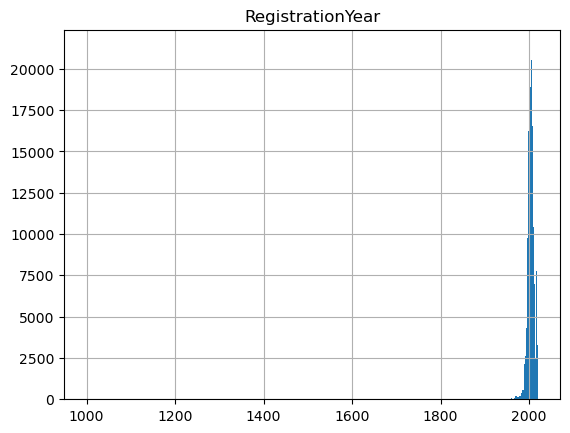

In [23]:
df.hist('RegistrationYear', bins=1000)

- Признаки **VehicleType**, **Gearbox**, **FuelType**

Данные параметры c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [24]:
df['VehicleType'] = df['VehicleType'].fillna(df
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [25]:
df['Gearbox'] = df['Gearbox'].fillna(df
                                         .groupby('Model')['VehicleType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [26]:
df['FuelType'] = df['FuelType'].fillna(df
                                           .groupby('Model')['VehicleType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

- Признак **Repaired**

In [27]:
df['Repaired'] = df['Repaired'].fillna('unknown')

**Посмотрим на получившиеся данные после обработки пропусков и выбросов:**

In [28]:
df[:10]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,754,768
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,744,766
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,747,747
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,761,767
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,765,767
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,762,766
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown,765,765
9,999,small,1998,manual,101,golf,150000,sedan,volkswagen,unknown,747,761
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,756,767
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes,768,768


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325909 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             325909 non-null  int64 
 1   VehicleType       325909 non-null  object
 2   RegistrationYear  325909 non-null  int64 
 3   Gearbox           325909 non-null  object
 4   Power             325909 non-null  int64 
 5   Model             325909 non-null  object
 6   Kilometer         325909 non-null  int64 
 7   FuelType          325909 non-null  object
 8   Brand             325909 non-null  object
 9   Repaired          325909 non-null  object
 10  DateCreated       325909 non-null  int64 
 11  LastSeen          325909 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.3+ MB


### 1.3. Кодирование категориальных признаков

- В признаке **Model** много категорий, попробуем совместить его с признаком **Brand** и закодировать значением: **Model.size() / Brand.size()**

In [30]:
df['brand_model'] = df['Brand'].astype(str) + ' ' + df['Model'].astype(str)

In [31]:
df['model_code'] = df['brand_model'].map(df.groupby('brand_model').size()) / \
                     df['Brand'].map(df.groupby('Brand').size())
df_coded = df.drop(['brand_model', 'Brand', 'Model'], axis=1)

- Признаки **VehicleType**, **Gearbox**, **FuelType**, **Repaired** закодируем **"OHE"** - (one-hot encoding).

In [32]:
# функция для кодирования "ohe"
def get_dummies_func(df, column, prefix):
    data = pd.get_dummies(df[column], prefix=prefix, drop_first=True)
    df = df.drop(column, axis=1)
    return df.join(data)

In [33]:
df_coded = get_dummies_func(df_coded, 'VehicleType', 'VType')

df_coded = get_dummies_func(df_coded, 'Gearbox', 'Gear')

df_coded = get_dummies_func(df_coded, 'FuelType', 'Fuel')

df_coded = get_dummies_func(df_coded, 'Repaired', 'Repair')

In [34]:
df_coded[:5]

,Price,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,model_code,VType_convertible,VType_coupe,VType_other,...,Fuel_hybrid,Fuel_lpg,Fuel_other,Fuel_petrol,Fuel_sedan,Fuel_small,Fuel_suv,Fuel_wagon,Repair_unknown,Repair_yes
0,480,1993,101,150000,754,768,0.396043,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,9800,2004,163,125000,744,766,0.373817,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,747,747,0.396043,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3600,2008,69,90000,761,767,0.388051,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,765,767,0.562788,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### 1.4. Подготовка выборок

In [35]:
X = df_coded.drop('Price', axis=1)
y = df_coded['Price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [37]:
f"Размер обучающей выборки: {X_train.shape}"

'Размер обучающей выборки: (260727, 36)'

In [38]:
f"Размер тестовой выборки: {X_test.shape}"

'Размер тестовой выборки: (65182, 36)'

- Проведём масштабирование признаков к стандартному нормальному распределению с помощью метода **StandardScaler** библиотеки **sklearn**

In [39]:
ss = StandardScaler()
ss.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(ss.transform(X_train), columns = columns)
X_test = pd.DataFrame(ss.transform(X_test), columns = columns)

In [40]:
X_train[:5]

,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,model_code,VType_convertible,VType_coupe,VType_other,VType_sedan,...,Fuel_hybrid,Fuel_lpg,Fuel_other,Fuel_petrol,Fuel_sedan,Fuel_small,Fuel_suv,Fuel_wagon,Repair_unknown,Repair_yes
0,0.553770,-0.699066,-1.312223,-0.086003,0.811626,-0.005285,-0.250995,-0.220396,-0.089568,-0.661661,...,-0.024389,-0.12236,-0.018991,0.783033,-0.183854,-0.143867,-0.036611,-0.102752,-0.466213,-0.329766
1,-0.402229,3.518713,0.579277,0.445649,0.375531,0.164824,-0.250995,-0.220396,-0.089568,-0.661661,...,-0.024389,-0.12236,-0.018991,0.783033,-0.183854,-0.143867,-0.036611,-0.102752,-0.466213,-0.329766
2,-0.593429,-0.830871,0.579277,1.721615,0.811626,0.882833,-0.250995,-0.220396,-0.089568,-0.661661,...,-0.024389,-0.12236,-0.018991,-1.277086,5.439100,-0.143867,-0.036611,-0.102752,2.144940,-0.329766
3,-0.211029,0.524843,0.579277,1.189963,0.702602,-0.741942,-0.250995,-0.220396,-0.089568,-0.661661,...,-0.024389,-0.12236,-0.018991,0.783033,-0.183854,-0.143867,-0.036611,-0.102752,-0.466213,-0.329766
4,-0.019829,0.581332,0.579277,1.615285,0.920650,1.833762,-0.250995,-0.220396,-0.089568,1.511347,...,-0.024389,-0.12236,-0.018991,-1.277086,-0.183854,-0.143867,-0.036611,-0.102752,-0.466213,-0.329766


**Вывод:**

1. Данные были успешно загружены и проанализированы. Типы данных соответствуют описанию, дубликаты удалены.


2. Отобраны признаки, необходимые для построения моделей.


3. Пропущенные значения, выбросы, а также неправдоподобные значения в признаках по возможности заполнены на основе имеющейся инфрмации. Остальные объекты удалены (около 8% данных).


4. Категориальные признаки с небольшой ординальностью преобразованы с помощью one-hot encoding. Признак Model закодирован по формуле Model.size() / Brand.size()


5. Данные разделены на тестовую и обучающую выборки в соотношении 1:4, признаки масштабированы к стандартному нормальному распределению.

## 2. Обучение моделей

- Для начала создадим константную base-line модель. Она всегда будет предсказывать среднее значение **Price**. (среднее значение на практике дало меньшее значение RMSE, чем медианное). Рассчитаем RMSE для base-line модели.

In [41]:
preds_base = pd.Series(data=y.mean(), index=y.index, dtype='int64')
rmse_base = mean_squared_error(y, preds_base) ** .5
f"RMSE для константной модели: {round(rmse_base, 2)}"

'RMSE для константной модели: 4530.45'

### 2.1. Линейная регрессия

- Сначала обучим линейную модель. затем посчитаем скорость обучения, скорость предсказания и RMSE модели. Обучение будем проводить с помощью кросс-валидации на 5-ти фолдов.

In [42]:
%%time
lm = LinearRegression()
score_lm = cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CPU times: user 2 s, sys: 483 ms, total: 2.49 s
Wall time: 437 ms


In [43]:
f"RMSE для линейной модели на валидационной выборке: {round((-score_lm.mean()) ** 0.5, 2)}"

'RMSE для линейной модели на валидационной выборке: 2983.38'

In [44]:
%%time
lm.fit(X_train, y_train)

CPU times: user 557 ms, sys: 200 ms, total: 757 ms
Wall time: 126 ms


LinearRegression()

In [45]:
%%time
preds_lm = lm.predict(X_train)

CPU times: user 23 ms, sys: 8.53 ms, total: 31.5 ms
Wall time: 6.99 ms


### 2.2 Lasso/Ridge

**1)  Lasso (L1 регуляризация) :**

In [46]:
%%time
alphas = np.arange(1, 40, 4)
for alpha in alphas :
    lasso = Lasso(alpha = alpha)
    mse = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print("RMSE для Lasso alpha={:.2f} модели на валидационной выборке: {:.2f}".format(alpha, (-mse.mean()) ** 0.5))

RMSE для Lasso alpha=1.00 модели на валидационной выборке: 2983.38
RMSE для Lasso alpha=5.00 модели на валидационной выборке: 2983.63
RMSE для Lasso alpha=9.00 модели на валидационной выборке: 2983.90
RMSE для Lasso alpha=13.00 модели на валидационной выборке: 2984.35
RMSE для Lasso alpha=17.00 модели на валидационной выборке: 2985.00
RMSE для Lasso alpha=21.00 модели на валидационной выборке: 2985.83
RMSE для Lasso alpha=25.00 модели на валидационной выборке: 2986.79
RMSE для Lasso alpha=29.00 модели на валидационной выборке: 2987.92
RMSE для Lasso alpha=33.00 модели на валидационной выборке: 2989.22
RMSE для Lasso alpha=37.00 модели на валидационной выборке: 2990.63
CPU times: user 49.1 s, sys: 6.74 s, total: 55.8 s
Wall time: 8.58 s


In [47]:
%%time
lasso = Lasso(alpha=0.1)
score_lasso = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CPU times: user 43.5 s, sys: 4.98 s, total: 48.5 s
Wall time: 7.65 s


In [48]:
f"RMSE для Lasso (L1 регуляризация) модели на валидационной выборке: {round((-score_lasso.mean()) ** 0.5, 2)}"

'RMSE для Lasso (L1 регуляризация) модели на валидационной выборке: 2983.38'

In [49]:
%%time
lasso.fit(X_train, y_train)

CPU times: user 9.97 s, sys: 879 ms, total: 10.8 s
Wall time: 1.64 s


Lasso(alpha=0.1)

In [50]:
%%time
preds_lasso = lasso.predict(X_train)

CPU times: user 24.1 ms, sys: 6.11 ms, total: 30.2 ms
Wall time: 5.52 ms


- Lasso не дало выигрыш в метрике, скорость обучения и предсказания немного выше, чем у Линейной модели без регуляризации.

**2) Ridge (L2 регуляризация) :**

In [51]:
%%time
alphas = np.arange(1, 40, 4)
for alpha in alphas :
    lasso = Lasso(alpha = alpha)
    mse = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print("RMSE для Lasso alpha={:.2f} модели на валидационной выборке: {:.2f}".format(alpha, (-mse.mean()) ** 0.5))

RMSE для Lasso alpha=1.00 модели на валидационной выборке: 2983.38
RMSE для Lasso alpha=5.00 модели на валидационной выборке: 2983.63
RMSE для Lasso alpha=9.00 модели на валидационной выборке: 2983.90
RMSE для Lasso alpha=13.00 модели на валидационной выборке: 2984.35
RMSE для Lasso alpha=17.00 модели на валидационной выборке: 2985.00
RMSE для Lasso alpha=21.00 модели на валидационной выборке: 2985.83
RMSE для Lasso alpha=25.00 модели на валидационной выборке: 2986.79
RMSE для Lasso alpha=29.00 модели на валидационной выборке: 2987.92
RMSE для Lasso alpha=33.00 модели на валидационной выборке: 2989.22
RMSE для Lasso alpha=37.00 модели на валидационной выборке: 2990.63
CPU times: user 46.6 s, sys: 4.07 s, total: 50.7 s
Wall time: 7.03 s


In [52]:
%%time
ridge = Ridge(alpha=0.5)
score_ridge = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CPU times: user 1 s, sys: 323 ms, total: 1.32 s
Wall time: 228 ms


In [53]:
f"RMSE для Ridge (L2 регуляризация) модели на валидационной выборке: {round((-score_ridge.mean()) ** 0.5, 2)}"

'RMSE для Ridge (L2 регуляризация) модели на валидационной выборке: 2983.38'

In [54]:
%%time
ridge.fit(X_train, y_train)

CPU times: user 144 ms, sys: 33.2 ms, total: 177 ms
Wall time: 30.3 ms


Ridge(alpha=0.5)

In [55]:
%%time
preds_ridge = ridge.predict(X_train)

CPU times: user 21 ms, sys: 8.55 ms, total: 29.6 ms
Wall time: 5.78 ms


- Ridge не дал выигрыш в метрике, но скорость обучения выше, чем у Линейной модели без регуляризации:
     - Ridge fit time: 60 ms
     - LinearRegression fit time: 127 ms


### 2.3 LightGBM

- Попробуем обучить модель с градиентным бустингом: LightGBM.
- Подбор параметров проведём с помощью GridSearch библиотеки sklearn.

In [56]:
# преобразование данных в формат Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [57]:
model = lgb.LGBMRegressor()

In [58]:
scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

In [59]:
# определение гиперпараметров
params = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 31,
          'learning_rate': 0.05,
          'feature_fraction': 0.9}

In [60]:
%%time
# обучение модели LightGBM
model_lgb = lgb.train(params,
                      train_data,
                      num_boost_round=100,
                      valid_sets=[train_data, test_data],
                      early_stopping_rounds=10)

/Users/artemvishanov/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 260727, number of used features: 36
[LightGBM] [Info] Start training from score 4621.914746
[1]	training's rmse: 4358.79	valid_1's rmse: 4408.15
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 4225.94	valid_1's rmse: 4274.12
[3]	training's rmse: 4083.38	valid_1's rmse: 4130.08
[4]	training's rmse: 3950.1	valid_1's rmse: 3995.48
[5]	training's rmse: 3825.52	valid_1's rmse: 3869.35
[6]	training's rmse: 3722.36	valid_1's rmse: 3765.16
[7]	training's rmse: 3626.54	valid_1's rmse: 3668.61
[8]	training's rmse: 3521.35	valid_1's rmse: 3562.61
[9]	training's rmse: 3422.7	valid_1's rmse: 3462.67
[10]	training's rmse: 3329.74	valid_1's rmse: 3368.5

In [61]:
%%time
predictions_lgb = model_lgb.predict(X_train)

CPU times: user 3.24 s, sys: 97.6 ms, total: 3.34 s
Wall time: 502 ms


In [65]:
f"RMSE для LightGBM модели на валидационной выборке: {round((-scores.mean()) ** 0.5, 2)}"

'RMSE для LightGBM модели на валидационной выборке: 1756.86'

**Вывод:**

- Проведено обучение моделей линейной регрессии без/с регуляризацией, а также модели градиентного бустинга LightGBM.
- Измерены время обучения/предсказания моделей, а так же качество предсказаний по метрике RMSE.


## 3. Анализ моделей

- Все обученные модели смогли улучшить RMSE базовой модели.
- Линейная модель без регуляризации для данной задачи показала качество предсказаний не хуже, чем Lasso и Ridge. Метрика **RMSE** для LightGBM в два раза ниже:

    - Base-line: 4530.45
    - LinearModel: 2983.38
    - Lasso 2980.98
    - Ridge 2980.98
    - LightGBM: 1768.28
    
    
- **По времени обучения** Ridge модель оказалась быстрее всех. Lasso значительно уступает линейной модели без регуляризации.:

    - LinearModel: 92.6 ms
    - Lasso 1.37 s
    - Ridge 28.4 ms
    - LightGBM: 511 ms
    
    
- **По времени предсказания** линейные модели ведут себя одинаково. LightGBM более тяжелая модель, время предсказания выше на порядок.

    - LinearModels: 4.54 ms
    - LightGBM: 380 ms

**Итог:**

В общем и целом можно сделать вывод, что модель **"LightGBM"**, одна из лучших моделей как по среднеквадратичной ошибке так и по времени обучения и предсказания:

Теперь посмотрим на предскказания тестовой выборки модели **"LightGBM"**:

In [66]:
%%time
preds_lgb_ff = model_lgb.predict(X_test)

CPU times: user 877 ms, sys: 10.5 ms, total: 887 ms
Wall time: 140 ms


In [67]:
%%time
rmse_ridge = mean_squared_error(y_test, preds_lgb_ff, squared=False)
f"RMSE для LightGBM модели на тестовой выборке: {round(rmse_ridge, 2)}"

CPU times: user 3.8 ms, sys: 3.36 ms, total: 7.16 ms
Wall time: 1.16 ms


'RMSE для LightGBM модели на тестовой выборке: 1859.15'